*This notebook is a modified version from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

and also [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)

# Linear Regression

## Introduction

||continuous|categorical|
|---|---|---|
|**supervised**|**regression**|classification|
|**unsupervised**|dimension reduction|clustering|


Why are we learning linear regression?
- widely used
- runs fast
- easy to use (not a lot of tuning required)
- highly interpretable
- basis for many other methods

Linear regression models are a good starting point for regression tasks.
Such models are popular because they can be fit very quickly, and are very interpretable.
You are probably familiar with the simplest form of a linear regression model (i.e., fitting a straight line to data) but such models can be extended to model more complicated data behavior.

In this section we will start with a quick intuitive walk-through of the mathematics behind this well-known problem, before seeing how before moving on to see how linear models can be generalized to account for more complicated patterns in data.

## Estimating ("Learning") Model Coefficients

Generally speaking, coefficients are estimated using the **least squares criterion**, which means we are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors"):

<img src="./img/08_estimating_coefficients.png">

What elements are present in the diagram?
- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the distances between the observed values and the least squares line.

How do the model coefficients relate to the least squares line?
- $\beta_0$ is the **intercept** (the value of $y$ when $x$=0)
- $\beta_1$ is the **slope** (the change in $y$ divided by change in $x$)

Here is a graphical depiction of those calculations:

<img src="./img/08_slope_intercept.png">

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = \beta_1 x + \beta_0
$$
where $\beta_1$ is commonly known as the *slope*, and $\beta_0$ is commonly known as the *intercept*.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

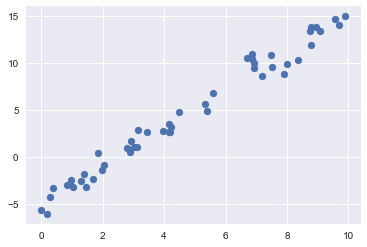

In [3]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

We can use Scikit-Learn's ``LinearRegression`` estimator to fit this data and construct the best-fit line:

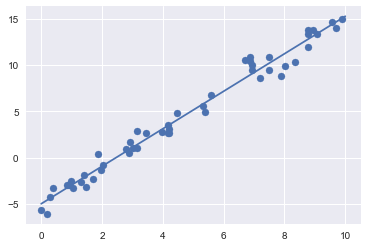

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are ``coef_`` and ``intercept_``:

In [5]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.02720881036
Model intercept: -4.99857708555


We see that the results are very close to the inputs, as we might hope.

The ``LinearRegression`` estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$
where there are multiple $x$ values.
Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [6]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5
[ 1.5 -2.   1. ]


Here the $y$ data is constructed from three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single ``LinearRegression`` estimator to fit lines, planes, or hyperplanes to our data.
It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

## Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.
We will use the ``PolynomialRegression`` pipeline..
The idea is to take our multidimensional linear model:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$
and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:
$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$
Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

### Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the ``PolynomialFeatures`` transformer:

In [7]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.
This new, higher-dimensional data representation can then be plugged into a linear regression.

The cleanest way to accomplish this is to use a pipeline.
Let's make a 7th-degree polynomial model in this way:

In [8]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$. 
For example, here is a sine wave with noise:

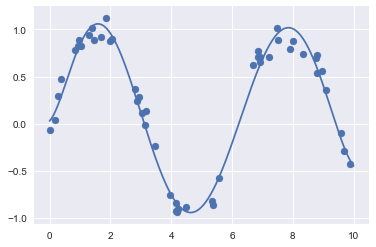

In [9]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data!

## Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) for a discussion of this).
For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

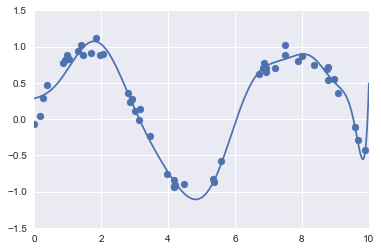

In [10]:
model = make_pipeline(PolynomialFeatures(16),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

With the data projected to the 16-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data.
We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

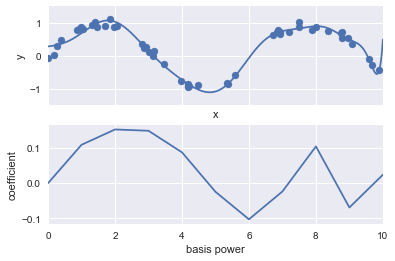

In [11]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].powers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis power',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(PolynomialFeatures(16), LinearRegression())
basis_plot(model)

The lower panel of this figure shows the amplitude of the basis function for each power of x.
This is typical over-fitting behavior: the coefficients of higher order basis functions oscillate and cancel each other out.
We know that such behavior is problematic, and it would be nice if we could limit such spikes expliticly in the model by penalizing large values of the model parameters.
Such a penalty is known as *regularization*, and comes in several forms.

### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*.
This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be 
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$
where $\alpha$ is a free parameter that controls the strength of the penalty.
This type of penalized model is built into Scikit-Learn with the ``Ridge`` estimator:

/Users/scherf/miniconda3/envs/presentation/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.1938775106195844e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)


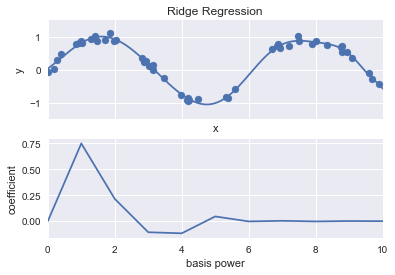

In [12]:
from sklearn.linear_model import Ridge
model = make_pipeline(PolynomialFeatures(16), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model.
In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.
One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

### Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:
$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$
Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor *sparse models* where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:

/Users/scherf/miniconda3/envs/presentation/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


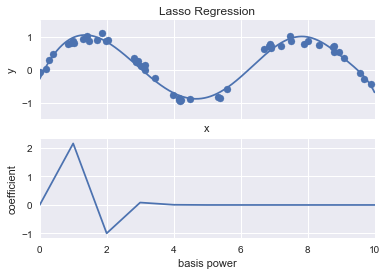

In [13]:
from sklearn.linear_model import Lasso
model = make_pipeline(PolynomialFeatures(16), Lasso(alpha=0.001, max_iter=100000))
basis_plot(model, title='Lasso Regression')

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions.
As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation.

## Variance and Bias

Let's have a look again at the problem of bias and variance of a Machine Learning model. This is related to the problem of underfitting and overfitting. Remember, the more complex your model is, the more variation in the data you can fit. Unfortunately, this also includes noise in the training data, i.e. variations that are not coming from the underlying signal you are interested in. On the other hand, if your model cannot represent the signal, it will fail to fit the general shape of your data (think a linear model fitted to a nonlinear function such as the sine function).

By playing with the number of polynomial basis functions (e.g. $x, x^2, x^3, ...$), also called the degree of the polynomial, you can produce different fits to the data. The degree can be changed via the **PolynomialFeatures(n)** option. You can play with this option below and observe the under- or over-fitting behaviour of the result.

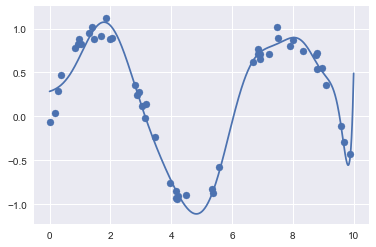

In [15]:
poly_model = make_pipeline(PolynomialFeatures(16),
                           LinearRegression())

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

To visualize the variance and the bias of the estimate, we can sample a number of datasets and compute how well the model fits and how much the fitted coefficients vary:
- To analyze the bias of the model, we compute the mean squared error between prediction and the target value y.
- To analyze the variance we can look at the variation of the fitted models. In order to compare models of different polynomial degrees, we will only look at the first coefficient (i.e. 'x' itself) which should exist in all models.

You can experiment with the code below by changing:
- The complexity of the model, i.e. the number of polynomial kernels: ```n_polynomial```
    - ```n_polynomial = 1``` gives us just the linear model
    - ```n_polynomial = 9``` uses coefficients $x, x^2, x^3, ..., x^9$ etc..
- With ```n_samples``` you can change the number of data points used in each experiment.
- With ```n_experiments``` you can set the number of experiments, i.e. how often you want to draw a random dataset and fit the model

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   4.,  13.,
         31.,  43.,  48.,  29.,  21.,   5.,   4.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([  0.        ,   1.66666667,   3.33333333,   5.        ,
          6.66666667,   8.33333333,  10.        ,  11.66666667,
         13.33333333,  15.        ,  16.66666667,  18.33333333,
         20.        ,  21.66666667,  23.33333333,  25.        ,
         26.66666667,  28.33333333,  30.        ,  31.66666667,
         33.33333333,  35.        ,  36.66666667,  38.33333333,
         40.        ,  41.66666667,  43.33333333,  45.        ,
         46.66666667,  48.33333333,  50.        ]),
 <a list of 30 Patch objects>)

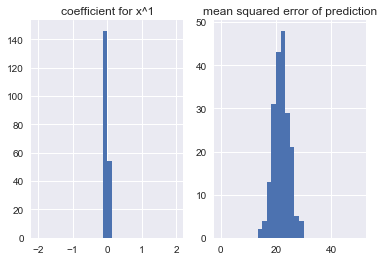

In [17]:
n_polynomial = 1
n_samples = 50
n_experiments = 200

poly_model = make_pipeline(PolynomialFeatures(n_polynomial),
                           LinearRegression())

fitted_coeffs = np.zeros((n_experiments,n_polynomial+1))
mse = np.zeros(n_experiments)

for i in range(n_experiments):
    rng = np.random.RandomState()
    x = 10 * rng.rand(n_samples)
    y = np.sin(x) + 0.1 * rng.randn(n_samples)

    poly_model.fit(x[:, np.newaxis], y)
    fitted_coeffs[i] = poly_model.steps[1][1].coef_
    y_hat=poly_model.predict(x[:,np.newaxis])
    mse[i]=np.sum((y_hat-y)**2)

plt.figure(1)
ax1=plt.subplot(121)
ax1.set_title("coefficient for x^1")
plt.hist(fitted_coeffs[:,1],30,range=[-2, 2])
ax2=plt.subplot(122)
ax2.set_title("mean squared error of prediction")
plt.hist(mse, 30, range=[0,50])

    

(array([ 200.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([  0.        ,   1.66666667,   3.33333333,   5.        ,
          6.66666667,   8.33333333,  10.        ,  11.66666667,
         13.33333333,  15.        ,  16.66666667,  18.33333333,
         20.        ,  21.66666667,  23.33333333,  25.        ,
         26.66666667,  28.33333333,  30.        ,  31.66666667,
         33.33333333,  35.        ,  36.66666667,  38.33333333,
         40.        ,  41.66666667,  43.33333333,  45.        ,
         46.66666667,  48.33333333,  50.        ]),
 <a list of 30 Patch objects>)

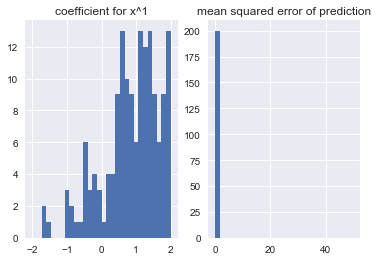

In [19]:
n_polynomial = 9
n_samples = 50
n_experiments = 200

poly_model = make_pipeline(PolynomialFeatures(n_polynomial),
                           LinearRegression())

fitted_coeffs = np.zeros((n_experiments,n_polynomial+1))
mse = np.zeros(n_experiments)

for i in range(n_experiments):
    rng = np.random.RandomState()
    x = 10 * rng.rand(n_samples)
    y = np.sin(x) + 0.1 * rng.randn(n_samples)

    poly_model.fit(x[:, np.newaxis], y)
    fitted_coeffs[i] = poly_model.steps[1][1].coef_
    y_hat=poly_model.predict(x[:,np.newaxis])
    mse[i]=np.sum((y_hat-y)**2)

plt.figure(1)
ax1=plt.subplot(121)
ax1.set_title("coefficient for x^1")
plt.hist(fitted_coeffs[:,1],30,range=[-2, 2])
ax2=plt.subplot(122)
ax2.set_title("mean squared error of prediction")
plt.hist(mse, 30, range=[0,50])

    

### things to test

- Increase number of samples used for fitting.
    - How does it influence overfitting for polynomials of higher order?
- Create a separate training and test set.
    - Use the training set to fit the model and the test set to validate the performance.
    - Test polyomial regression models of increasing order. How do the different models generalize (i.e. how well do they perform on the test set)?
    - How does regularization influence the generalization of your models?

## Example: Predicting Bicycle Traffic

As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

We will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor.
Fortunately, the NOAA makes available their daily [weather station data](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (I used station ID USW00024233) and we can easily use Pandas to join the two data sources.
We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

In particular, this is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning.
As discussed previously, this is not a standard approach within machine learning, but such interpretation is possible for some models.

Let's start by loading the two datasets, indexing by date:

In [14]:
# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

![](img/fremont-bridge.jpg)

In [397]:
import pandas as pd
daily = pd.read_csv('data/daily_counts_weather.csv', index_col='Date', parse_dates=True)

In [398]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Date,,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000,3463.400275
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740,3361.947831
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479,3160.933823
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219,1908.094174
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959,1870.448616


With this in place, we can choose the columns to use, and fit a linear regression model to our data.
We will set ``fit_intercept = False``, because the daily flags essentially operate as their own day-specific intercepts:

In [401]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

#put in the columns you want to use as predictor variables

column_names = ['daylight_hrs'] 


X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

Finally, we can compare the total and predicted bicycle traffic visually:

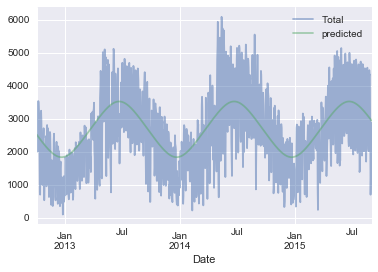

In [402]:
daily[['Total', 'predicted']].plot(alpha=0.5);

A simple regression on the hours of daylight at least partially explains the general trend. Now just go back and add more predictor variables and see how the fit changes. 

It is evident that we have missed some key features, especially during the summer time.
Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).
Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [403]:
params = pd.Series(model.coef_, index=X.columns)
params

daylight_hrs    223.289445
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty.
We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [404]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

With these errors estimated, let's again look at the results:

In [405]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
daylight_hrs   223.0    3.0


The effect column will show you for each variable how the total number of people taking the bike changes if you change the variable by 1 unit. E.g. for each additional hour of daylight there are 223 more people (on their bikes) crossing the bridge.  

Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation *and* cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model.
Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days).
These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

## Additional topics

### 01 - Gaussian basis functions

Of course, other basis functions are possible.
For example, one useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases.
The result might look something like the following figure:

![](./img/05.06-gaussian-basis.png)

The shaded regions in the plot are the scaled basis functions, and when added together they reproduce the smooth curve through the data.
These Gaussian basis functions are not built into Scikit-Learn, but we can write a custom transformer that will create them, as shown here and illustrated in the following figure (Scikit-Learn transformers are implemented as Python classes; reading Scikit-Learn's source is a good way to see how they can be created):

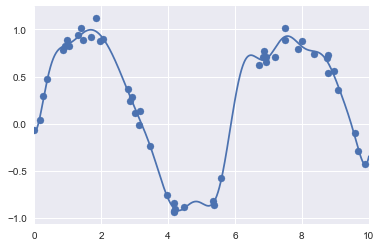

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

We put this example here just to make clear that there is nothing magic about polynomial basis functions: if you have some sort of intuition into the generating process of your data that makes you think one basis or another might be appropriate, you can use them as well.

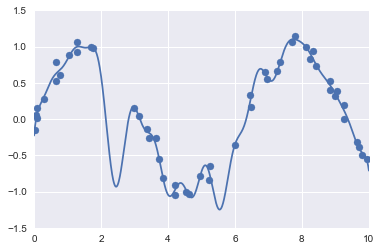

In [237]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

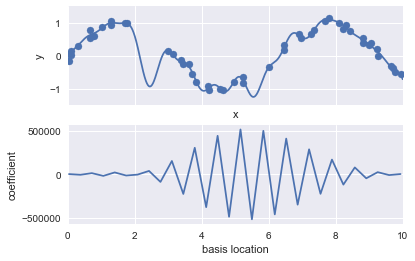

In [243]:
def basis_plot_gauss(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot_gauss(model)

### things to test

- Use regularization as above in the polynomial examples.
- What happens to the coefficients when you use regularization?

## 02 - Create data frames with pandas

In [ ]:
import pandas as pd
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

Let's get a quick overview of the data. Each pandas dataframe has the function .head() that shows the first couple of rows.

In [379]:
counts.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


Next we will compute the total daily bicycle traffic, and put this in its own dataframe:

In [380]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

Summing the counts for each day can be done in pandas using _resample_.

In [381]:
daily=counts.resample('d').sum()
daily.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03,1760.0,1761.0
2012-10-04,1708.0,1767.0
2012-10-05,1558.0,1590.0
2012-10-06,1080.0,926.0
2012-10-07,1191.0,951.0


In [382]:
daily['Total'] = daily.sum(axis=1) #sum counts for both columns (i.e. both sides of the bridge)
daily = daily[['Total']] # remove other columns
daily.head()

,Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0


The patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:

In [383]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [384]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [385]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

(8, 17)

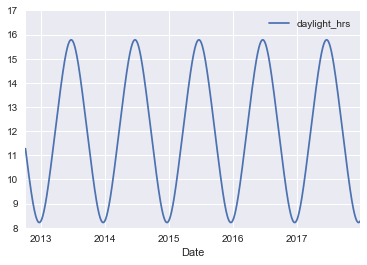

In [386]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

We can also add the average temperature and total precipitation to the data.
In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [387]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10

weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

Finally, let's add a counter that increases from day 1, and measures how many years have passed.
This will let us measure any observed annual increase or decrease in daily crossings:

In [388]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

Now our data is in order, and we can take a look at it:

In [424]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Date,,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000,2518.115289
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740,2505.115904
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479,2492.141875
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219,2479.195323
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959,2466.278412
